### Import the dataset and using pandas_profiling for preliminary exploratory analysis

In [27]:
from pathlib import Path

import requests
import numpy as np
import pandas as pd

import pandas_profiling
from pandas_profiling.utils.cache import cache_file
#for performing sql query on pandas df
import pandasql as ps

import matplotlib.pyplot as plt
import seaborn as sns


In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
#Load the Kaggle cardiovascular dataset

full_data = pd.read_csv('cardio_train.csv', sep=";", index_col='id')

print(f"The cardiovascular dataset shape is {full_data.shape}");
full_data.head()

The cardiovascular dataset shape is (70000, 12)


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [30]:
#Perform the following feature engineering:
#1. combine height and weight into BMIs
#BMI is calculated as weight(kg) / height(m)^2

full_data['BMI'] = full_data.weight / (full_data.height/100)**2


In [31]:
#Convert gender to F (1) and M (2)
#gender = 1 is women and 2 is men
full_data.gender = ['F' if g == 1 else 'M' for g in full_data.gender]

In [32]:
#Convert age from days to years
full_data['age'] = full_data.age / 365.0

In [33]:
'''
Convert Cholesterol and glucose levels to categorical values: normal (1), above normal (2) 
and well above normal (3)
'''
def to_category(x):   
    if x == 1:
        return 'normal'
    elif x == 2:
        return 'above normal'
    elif x == 3:
        return 'well above normal'
    return None
    
full_data['cholesterol'] = [to_category(x) for x in full_data.cholesterol]
full_data['gluc'] = [to_category(x) for x in full_data.gluc]




In [35]:
#set smoke, alco and active as categorical variables
full_data['smoke'] = ['Y' if x == 1 else 'N' for x in full_data.smoke]
full_data['alco'] = ['Y' if x == 1 else 'N' for x in full_data.alco]
full_data['active'] = ['Y' if x == 1 else 'N' for x in full_data.active]




### Using pandas profile report for preliminary sanity check of the data

In [36]:
df = full_data
    

#I am not seen the differences with explorative=True???
profile_report = df.profile_report(explorative=True, html={'style': {'full_width': True}})
profile_report

#How to display the widget instead???
profile_report.to_widgets()

Summarize dataset:   0%|          | 0/28 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

### Save report as html

In [37]:
profile_report.to_file("Capstone2_data_wrangling.html")

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### A few issues observed through pandas profiling report: [CLICK HERE](https://htmlpreview.github.io/?https://raw.githubusercontent.com/wh2353/datasciencecamp/main/SpringBoard_DS_track/DataScienceCapstone2/Capstone2_data_wrangling.html)
<b>1. There is no missing values in any of the features;<b>
2. Abnormal values of heights (min = 55cm and max = 250cm), which may further result in abnormal BMIs<br>
3. There are abnormal values in ap_hi and ap_lo columns: in specific, the minimal value is negative, and there are extremely high entries (such as those > 10000), which apparenly are incorrect;<br>
4. ap_hi needs to be larger than ap_lo for a specific patient; <br>
5. Remove Height and Weights from the dataset as they are strongly correlated with BMI. Other variables are mostly independent from other other.<br>
6. Most binary variables are severely unbalanced, such as gender, cholesterol, gluc, smoke, alco, active. Catboost encoder will be applied to numerize categorical variables.</b>




In [38]:
#check samples with BMI > 100

full_data.loc[full_data.BMI>=100, ]

#it seems height or weight might be reversed or in some other scale (inches ft or lbs)



,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
id,,,,,,,,,,,,,
8757,57.506849,F,122,161.0,120,80,normal,normal,N,N,Y,1,108.169847
10843,40.167123,M,70,72.0,120,8,normal,normal,N,N,Y,0,146.938776
11662,48.345205,M,97,170.0,160,100,normal,normal,Y,N,Y,1,180.678074
18218,53.682192,F,75,168.0,120,80,normal,normal,Y,N,Y,1,298.666667
18928,61.523288,M,71,68.0,120,80,well above normal,normal,N,N,Y,0,134.893870
20459,60.287671,F,67,57.0,120,90,normal,normal,N,N,Y,1,126.977055
21686,43.320548,F,70,68.0,120,80,normal,normal,N,N,N,0,138.775510
21958,47.684932,F,125,167.0,180,90,normal,above normal,N,N,Y,1,106.880000
23859,53.917808,M,74,98.0,140,90,normal,normal,N,N,Y,1,178.962747


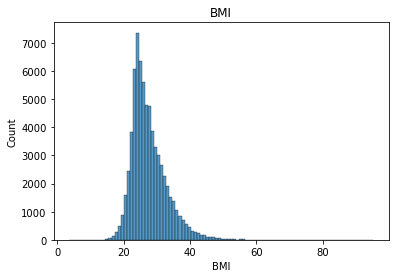

In [39]:
#Remove samples with BMI > 100
full_data = full_data.loc[full_data.BMI<=100]

#Plot The BMI histogram
sns.histplot(full_data.BMI, bins=100);
plt.title('BMI')
plt.show()

In [40]:
#Remove samples with abnormal height
print(f"The samples with height> 220cm are:\n{full_data.loc[full_data.height>=220]}")
print(f"The samples with height<= 120cm are:\n{full_data.loc[full_data.height<=120]}")

#only keep those height between 120 and 220cm

full_data = full_data.loc[np.logical_and(full_data.height>120, full_data.height<220)]

The samples with height> 220cm are:
            age gender  height  weight  ap_hi  ap_lo        cholesterol  \
id                                                                        
9223  58.136986      F     250    86.0    140    100  well above normal   

        gluc smoke alco active  cardio    BMI  
id                                             
9223  normal     N    N      Y       1  13.76  
The samples with height<= 120cm are:
             age gender  height  weight  ap_hi  ap_lo        cholesterol  \
id                                                                         
309    59.726027      M      76    55.0    120     80             normal   
4838   39.769863      F     100    70.0    100     70             normal   
5278   48.334247      F     120    70.0    120     70             normal   
5306   42.191781      F     120    30.0    110     70             normal   
5946   44.136986      F     120    80.0    120     80             normal   
9721   58.643836      M  

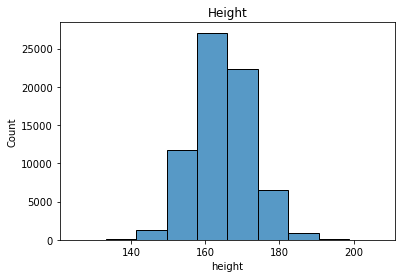

In [41]:
#Check the new distribution of height

sns.histplot(full_data.height, bins=10);
plt.title('Height')
plt.show()

In [53]:
#Drop the height and weight column, only keep BMI
full_data.drop(columns=['height', 'weight'], inplace=True)

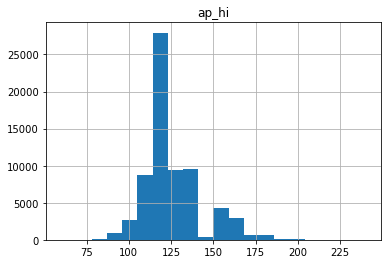

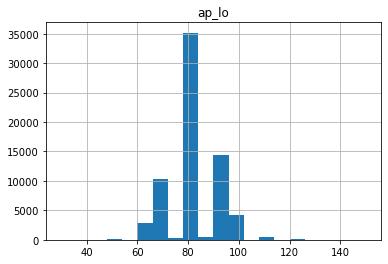

In [54]:
'''
Set maximal value as 500, minimal as 0, check histogram of ap_hi and ap_lo
'''

full_data.loc[np.logical_and(full_data.ap_hi>0, full_data.ap_hi<500)].hist(column='ap_hi', bins=20);
full_data.loc[np.logical_and(full_data.ap_lo>0, full_data.ap_lo<500)].hist(column='ap_lo', bins=20);

In [55]:
'''
Filtering criteria: ap_hi between 50-250, ap_lo between 25-150 and ap_hi>ap_lo
'''


query = """SELECT * FROM full_data WHERE (ap_hi BETWEEN 50 AND 250) AND \
(ap_lo BETWEEN 25 AND 150) AND (ap_lo < ap_hi)"""


trimmed_data = ps.sqldf(query)

full_data = trimmed_data.set_index('id')


print(f"The final data shape is {full_data.shape}\n")


The final data shape is (68588, 11)



In [56]:
#check the dtype of current data
full_data.dtypes

age            float64
gender         float64
ap_hi            int64
ap_lo            int64
cholesterol    float64
gluc           float64
smoke          float64
alco           float64
active         float64
cardio           int64
BMI            float64
dtype: object

In [57]:
#catboostEncoder to numerise categorical variables,
#including gender, cholesterol, gluc, smoke, alco and active
import category_encoders as ce
#compare catboostEncoder vs TargetEncoder
train = full_data[['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']]

target = full_data.cardio

cbe_encoder = ce.cat_boost.CatBoostEncoder()
cbe_res = cbe_encoder.fit_transform(train, target)


print(cbe_res)






         gender  cholesterol      gluc     smoke      alco    active
id                                                                  
0      0.494708     0.494708  0.494708  0.494708  0.494708  0.494708
1      0.494708     0.494708  0.247354  0.247354  0.247354  0.247354
2      0.747354     0.747354  0.498236  0.498236  0.498236  0.494708
3      0.247354     0.247354  0.623677  0.623677  0.623677  0.498236
4      0.831569     0.498236  0.698942  0.698942  0.698942  0.747354
...         ...          ...       ...       ...       ...       ...
99993  0.499519     0.435389  0.475606  0.468516  0.495726  0.485437
99995  0.492121     0.596460  0.588240  0.497226  0.495718  0.485428
99996  0.499498     0.762434  0.475598  0.497234  0.476508  0.532564
99998  0.492132     0.435381  0.588321  0.497242  0.495726  0.532599
99999  0.492143     0.596503  0.475607  0.497250  0.495734  0.485437

[68588 rows x 6 columns]


In [58]:
#replace cateogrical variables with numeric values from catboost Encoder
full_data[['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']] = cbe_res


### Double checking the processed data

In [59]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68588 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          68588 non-null  float64
 1   gender       68588 non-null  float64
 2   ap_hi        68588 non-null  int64  
 3   ap_lo        68588 non-null  int64  
 4   cholesterol  68588 non-null  float64
 5   gluc         68588 non-null  float64
 6   smoke        68588 non-null  float64
 7   alco         68588 non-null  float64
 8   active       68588 non-null  float64
 9   cardio       68588 non-null  int64  
 10  BMI          68588 non-null  float64
dtypes: float64(8), int64(3)
memory usage: 6.3 MB


In [60]:
#Some of the features, such as gender, gluc, smoke seems severely imbalnced. 
#Such caveat will be handling during the model training process
full_data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,68588.0,53.328843,6.761524,29.583562,48.378082,53.978082,58.424658,64.967123
gender,68588.0,0.493431,0.007365,0.178193,0.491064,0.492828,0.495649,0.831569
ap_hi,68588.0,126.671357,16.681576,60.000000,120.000000,120.000000,140.000000,240.000000
ap_lo,68588.0,81.297618,9.435144,30.000000,80.000000,80.000000,90.000000,150.000000
cholesterol,68588.0,0.493552,0.112710,0.103946,0.432992,0.435053,0.481042,0.941737
gluc,68588.0,0.493445,0.045571,0.211335,0.473681,0.475563,0.476326,0.775680
smoke,68588.0,0.493440,0.010010,0.164903,0.492289,0.496575,0.497270,0.698942
alco,68588.0,0.493401,0.007590,0.164903,0.491326,0.495305,0.495746,0.698942
active,68588.0,0.493286,0.019783,0.232981,0.482924,0.484895,0.487158,0.747354
cardio,68588.0,0.494708,0.499976,0.000000,0.000000,0.000000,1.000000,1.000000


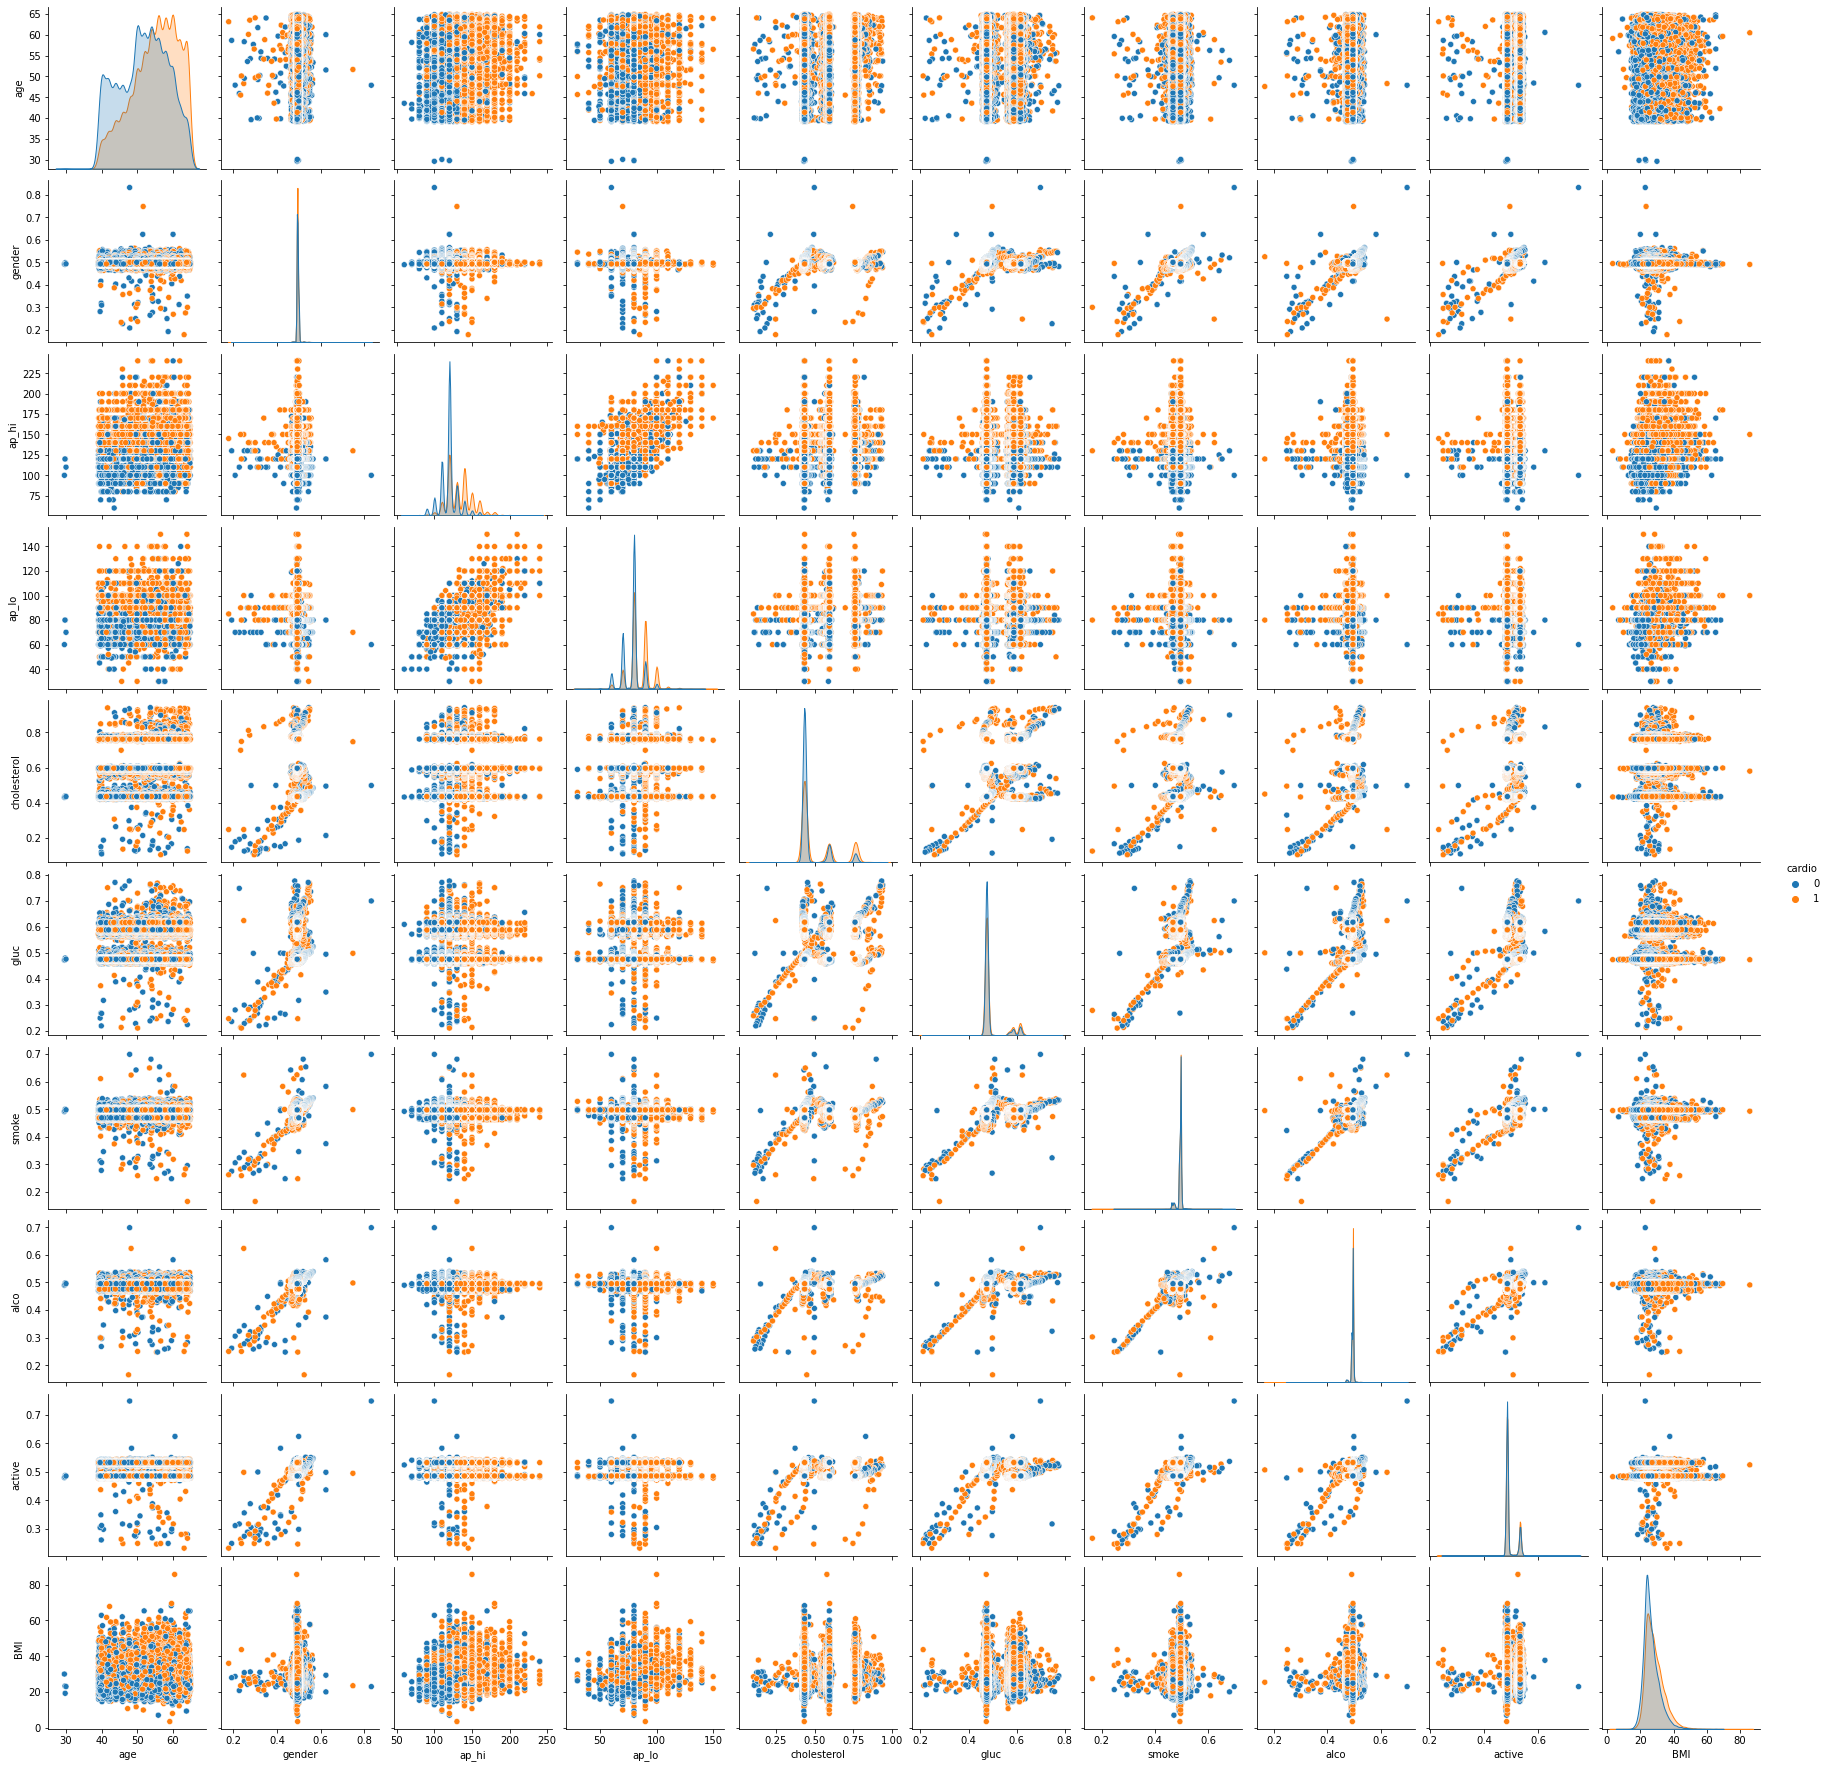

In [61]:
'''
View processed dataset through seaborn pairplot
selected variables are age, gender, height, weight
'''

sns.pairplot(full_data, hue='cardio');
plt.show();

### Based on the pairplot above, there are clear separations between healthy individuals and cardiovascular diseased patients. However, strong correlations among categorical variables numerized by catboost encoder were observed.

In [62]:
#save data for further processing
full_data.to_csv("cardiovascular_data_after_data_wrangling.csv")